In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from matplotlib.gridspec import GridSpec
from pymultitaper import multitaper_spectrogram

from iEEG_utils.processing import filtering
from iEEG_utils.loading import read_data
from iEEG_utils.processing.bumps import get_bump_ixs

from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.ndimage import uniform_filter as unifilt
from scipy.ndimage import gaussian_filter1d as gfilt

from fooof import FOOOF
from fooof.core.funcs import lorentzian_function
from fooof.utils import interpolate_spectrum
from fooof.utils import interpolate_spectra
from fooof.utils.params import compute_time_constant
from fooof.utils.params import compute_knee_frequency


C:\Users\jmile3\AppData\Local\Temp\ipykernel_12456\3967081669.py:20: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [103]:
# load in channel montage and data
fstr = r"C:\Users\jmile3\OneDrive - SCH\resting_state\sub12_fca96e"

# sep and header may need adjustment based on datasource
# not all subj will have a referencing montage, but some will
chs = pd.read_csv(fstr+r"\RestingState_"+fstr[-6::]+"_montage.csv",sep=",",header=0)

# load in data
[origfs,data] = read_data.load_iEEG(fstr,chs=list(chs.ch.dropna()))

display(chs)
print("sampling rate:",origfs)

,ID,age,region,ch
0,fca96e,31.33,Middle_frontal_gyrus,NaN
1,fca96e,31.33,Middle_frontal_gyrus,NaN
2,fca96e,31.33,Precentral_gyrus,GRID33
3,fca96e,31.33,Precentral_gyrus,GRID25
4,fca96e,31.33,Postcentral_gyrus,GRID34
5,fca96e,31.33,Postcentral_gyrus,GRID26
6,fca96e,31.33,Supramarginal_gyrus,NaN
7,fca96e,31.33,Supramarginal_gyrus,NaN
8,fca96e,31.33,Superior_temporal_gyrus,GRID42
9,fca96e,31.33,Superior_temporal_gyrus,GRID49


sampling rate: 1220.703125


In [158]:
# resample data to common sampling rate and filter
nch = 5

resrate = 1024 # common resampling rate for dataset
fmin = 0.5
fmax = 100
t_win = 1
t_res = 1/4
f_res = 1/2 # (resrate/nfft for 1 sec window)

subdata = data.loc[:,chs.ch[chs.region==chs.region.unique()[nch]]]
hpfdata = subdata-subdata.rolling(window=int(origfs),min_periods=int(origfs/2),center=True).mean()
[ts, normdata, filt_wins] = filtering.filt_resample(hpfdata, origfs, resrate, lpfreq=150, norm='zscore')
# bipolar re-referencing (subtracting adjacent, within-gyrus electrode pairs)
bip_ch = np.squeeze(np.diff(normdata,axis=1))
# calculate spectra
# spectra,f,sts = filtering.calc_spectra(bip_ch, resrate, t_res=t_res, f_res=f_res)
f,sts,spectra = multitaper_spectrogram(bip_ch,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[0.5, 100],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)
# slight smoothing in frequency (3) and time (5)
smoothspect = unifilt(spectra.T, [3,5], mode="nearest")
# don't bother with part of spectrum above 100 Hz
freqs = f[(f>0)&(f<=100)]
# smooth the spectra between the 60 Hz filter - otherwise there will be a sharp dip
_,smoothspect = interpolate_spectra(freqs, smoothspect, [58.5,61.5], buffer=5)

In [163]:
# set up plot
def fig_plot():
    plt.close('all')
    fig = plt.figure(figsize=(6,2),tight_layout=True)
    
    gs = GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.set_prop_cycle('color',plotcmap)
    ax2.set_prop_cycle('color',plotcmap)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    # ax2.set_facecolor([0.9, 0.7, 0.8])
    ax2.set_xlabel("log(Frequency)")
    ax2.set_ylabel("log(norm. power)")
    return [ax1,ax2,fig]


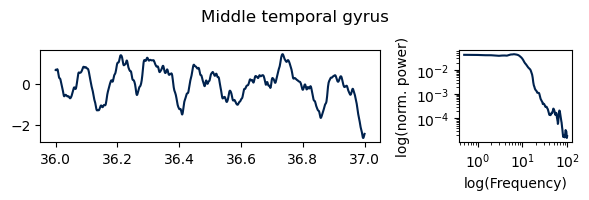

In [181]:
# look at some segments of data alongside their power spectra
plt.close()
[ax1,ax2,fig] = fig_plot()
nspec = 1
s0 = random.randint(1,np.shape(spectra)[0])
plot_ts = np.where((ts >= sts[s0]-0.5)&(ts<=sts[s0]+0.5))
plotcmap = plt.cm.cividis(np.linspace(0,1,nspec))
ax1.plot(ts[plot_ts],bip_ch[plot_ts],linewidth=1.5)
ax2.plot(f[(f>0)&(f<=100)], smoothspect[s0:s0+nspec,(f>0)&(f<=100)].T)
fig.suptitle(chs.region.unique()[nch].replace("_"," "))
plt.show()